# Random Number Decomposition (python)
Idea: Decompose the sum of random numbers into its contributions

for a given set of $x_i$ and $a_{ik}$ with
$$x_i = \Sigma_{j=0}^n \Sigma_{k=1}^{m_j} a_{ik}y_{jk}$$ 
with
* $m_j$ being the number of contributers of layer j
* $y_{jk}$ being the k-th contribution of layer j
* $m_0 = 1$ by default
* $a_{ik} \in \{0, 1\}$
* $\Sigma a_{ik} = 1$ only one contributer per layer

calculate the Distributions $y_{k} \sim N(μ_{k}, σ_{k})$
Boundary conditions:
* $\Sigma _{k} μ_k = 0$ via $μ_{m_j} = -\Sigma_{k = 1}^{m_j-1} μ_{k}$

In [3]:
import numpy as np
import pyro
import pyro.distributions as dist
import pyro.optim as optim
import torch
import os
import matplotlib.pyplot as plt
import logging
import seaborn as sns

%matplotlib inline
plt.style.use('default')

logging.basicConfig(format='%(message)s', level=logging.INFO)
smoke_test = ('CI' in os.environ)

c:\Users\fuerf\AppData\Local\Programs\Python\Python312\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## Initialize the data

In [4]:
n_samples = 1000

n_contributers = [2, 4] # one influencer in level 1 and 4 on level 1

## setup the individual random generators

In [6]:
def align_coefficients(coefs):
    """ensure that the average over all contributers per level is 0"""
    mem = {}
    for level, lcoefs in coefs.items():
        avg = np.mean([m for (m, s) in lcoefs.values()])
        mem[level] = {k: (m-avg, s) for k, (m,s) in lcoefs.items()}
    
    return mem
def gen_contributer_coefficients(n_contributers, contributer_avg, contributer_sig):
    """creates for n_contributers the average and standard deviation
    Input:
    * n_contributers: list with number of influencers for each level
    * contributer_avg: average for the average of the influencers
    * contributer_sig: average for the stdev for the influencers (lognormal distribution) 
     
    Output:
    Dictionary {level : { influencer: (mu, sigma)}} with the coefficients for every
    influencer in each level
    """
    assert n_contributers[0] == 1, "First level is allowed to have one contributer"
    return align_coefficients({lvl : {i : (np.random.normal(contributer_avg), np.random.lognormal(contributer_sig)) for i in range(num)} for lvl, num in enumerate(n_contributers)})

def print_coefficients(contributer_coefficients):
    contributer_coefficients = align_coefficients(contributer_coefficients)
    for m, stage in contributer_coefficients.items():
        for i, (mu, sig) in stage.items():
            print(f"Stage {m}: Contributer {i} mu={mu:.2f}, sig={sig:.2f}")

In [1]:
# easy as a start
cc_02 = {0: {    0: (0, 5)},
        1: {    0: (0, 1),
                1: (0, 1),
                2: (0, 1),
                3: (4, 2)}}
cc_01 = { 
        0: {    0 : (0, 5)},
        1: {    0: (1, 1),
                1: (-1, 1)}}

In [8]:
print_coefficients(cc_02)

Stage 0: Contributer 0 mu=0.00, sig=5.00
Stage 1: Contributer 0 mu=-1.00, sig=1.00
Stage 1: Contributer 1 mu=-1.00, sig=1.00
Stage 1: Contributer 2 mu=-1.00, sig=1.00
Stage 1: Contributer 3 mu=3.00, sig=2.00


## Create the Data

In [9]:
def gen_data(contributer_coefficients, n_samples):
    """generate random data.
    The first level defines the baseline that holds for all random numbers
    
    Inputs:
    * n_samples: number of samples
    * contributer_coefficients: dictionary with (mean,sig) per level per contributer
    
    Outputs:
    * data: array with the final number
    * contributers: matrix defining the contributers, first column is for the first level"""
    
    assert len(cc_01[0]) == 1, "Level 0 defines the baseline. It should have exactly one contributer"
    #data = np.random.normal(gen_avg, gen_sig, n_samples)
    data = np.zeros((n_samples, ))
    contributers = np.zeros((n_samples, len(contributer_coefficients)))
    for lvl, cdict in contributer_coefficients.items():
        print(f"creating level {lvl}")
        lvl_influencers = len(cdict) #number of influencers in this level
        lvldata = np.zeros((n_samples, lvl_influencers))

        for i, (mu,sig) in cdict.items():
            lvldata[:,i] = np.random.normal(mu, sig, n_samples)

        selection = np.random.randint(low=0,
                                    high=lvl_influencers,
                                    size=(n_samples))
        contributers[:, lvl] = selection
        
        data += np.array([lvldata[row, col] for row, col in enumerate(selection)])
        # Note: The first level 
    return torch.from_numpy(data), torch.from_numpy(contributers[:, 1:]).to(torch.int64)

In [10]:
# generate the data
data, contributers = gen_data(n_samples=n_samples,
                              contributer_coefficients=cc_01)

creating level 0
creating level 1


In [11]:
contributers = contributers.squeeze(-1)

In [31]:
# idea: use onehot matrix to implement the if-condition in vectorized form
def onehot(indices, n_cons=None):
    """create the onehot matrix of a vector.
    If not all contributers appear , n_cons defines how many there should be"""
    
    assert len(indices.shape) == 1, "indices need to be a vector"
    n_rows = indices.shape[0]
    if n_cons is None:
        n_cons = torch.max(indices).item()+1
    return torch.zeros(n_rows, n_cons).scatter_(1, indices.unsqueeze(1), 1)

In [32]:
pyro.clear_param_store()
"""
def model(contributers, data):
    
    a = pyro.sample("a", dist.Normal(0., 10.))
    b_0 = pyro.sample("b1", dist.Normal(0., 1.))
    b_1 = pyro.sample("b2", dist.Normal(0., 1.))

    sigma = pyro.sample("sigma", dist.Uniform(0., 10.))
    mean = a + (contributers == 0) * b_0 + (contributers == 1) * b_1
    
    with pyro.plate("data", len(data)):
        pyro.sample("obs", dist.Normal(mean, sigma), obs=data)
"""

def model0(contibuters, data):
    """simplest model with only one normal distribution"""
    m = pyro.sample("m", dist.Normal(0, 1))
    sd = pyro.sample("sd", dist.LogNormal(m, 1))
    with pyro.plate("N", len(data)):
        pyro.sample("obs", dist.Normal(m, sd), obs=data)

def model(contributers, data):
    assert len(data.shape) == 1
    assert len(contributers.shape) == 1
    a_m = pyro.param("a_m", dist.Normal(0., 10.))
    a_s = pyro.param("a_s", dist.LogNormal(4, 10.))

    n_cons = 2
    #cons = []
    #with pyro.plate("contributers", n_cons-1) as con:
    #    cons.append(pyro.param()

    b_0_m = pyro.param("b_0_m", dist.Normal(0., 1.))
    b_0_s = pyro.param("b_0_s", dist.LogNormal(2., 1.))

    #b_1_m = pyro.param("b_1_m", dist.Normal(0., 1.))
    b_1_s = pyro.param("b_1_s", dist.LogNormal(2., 1.))

    #sigma = pyro.sample("sigma", dist.Uniform(0., 10.))
    #mean = a + (contributers == 0) * b_0 + (contributers == 1) * b_1
    #with pyro.plate("contributers", len(contributers)):

    # this is not correct. The vectors b0 and b1 should be of the same size
    with pyro.plate("contributers", len(contributers)):
        b0 = pyro.sample("b0", dist.Normal( b_0_m, b_0_s), obs_mask=contributers==0, obs=contributers)
        b1 = pyro.sample("b1", dist.Normal(-b_0_m, b_1_s), obs_mask=contributers==1, obs=contributers)

    #m = a_m + b0 + b1
    #print(m.shape)
    m = pyro.deterministic("m", a_m + b0 + b1)

    with pyro.plate("data", len(data)):
        
        pyro.sample("obs", dist.Normal(m, a_s)
                           , obs=data)
    
def model1(contributers, data):
    assert len(data.shape) == 1
    assert len(contributers.shape) == 1
    a_m = pyro.param("a_m", dist.Normal(0., 10.))
    a_s = pyro.param("a_s", dist.LogNormal(4, 10.))

    n_cons = 2
    #cons = []
    #with pyro.plate("contributers", n_cons-1) as con:
    #    cons.append(pyro.param()

    b_0_m = pyro.param("b_0_m", dist.Normal(0., 1.))
    b_0_s = pyro.param("b_0_s", dist.LogNormal(2., 1.))

    #b_1_m = pyro.param("b_1_m", dist.Normal(0., 1.))
    b_1_s = pyro.param("b_1_s", dist.LogNormal(2., 1.))

    b0 = pyro.sample("b0", dist.Normal( b_0_m, b_0_s))
    b1 = pyro.sample("b1", dist.Normal(-b_0_m, b_1_s))

    #m = a_m + b0 + b1
    #print(m.shape)
    m = pyro.deterministic("m", a_m + torch.mul((contributers == 0), b0) + torch.mul((contributers == 1), b1))

    with pyro.plate("data", len(data)):
        
        pyro.sample("obs", dist.Normal(m, a_s)
                           , obs=data)

In [33]:
trace = pyro.poutine.trace(model1).get_trace(contributers[:64], data[:64])
print(trace.format_shapes())

Trace Shapes:        
 Param Sites:        
          a_m        
          a_s        
        b_0_m        
        b_0_s        
        b_1_s        
Sample Sites:        
      b0 dist    |   
        value    |   
      b1 dist    |   
        value    |   
       m dist    | 64
        value    | 64
    data dist    |   
        value 64 |   
     obs dist 64 |   
        value 64 |   


In [14]:
from pyro.infer.autoguide import AutoMultivariateNormal, init_to_mean
from pyro.infer import SVI, Trace_ELBO


def get_svi(model):
    guide = AutoMultivariateNormal(model, init_loc_fn=init_to_mean)
    svi = SVI(model,
            guide,
            optim.Adam({"lr": .01}),
            loss=Trace_ELBO())
    return guide, svi

In [15]:
def plotter(guide, contributers, data, variables):
    with pyro.plate("samples", 1000, dim=-1):
        samples = guide(contributers, data)

    assert type(variables) == list

    fig = plt.figure(figsize=(10, 6))
    for var in variables:
        sns.histplot(samples[var].detach().cpu().numpy(), kde=True, stat="density", label=var)

    plt.legend()
    plt.show()

In [34]:
num_iters = 2000 if not smoke_test else 2
guide, svi = get_svi(model1)

for i in range(num_iters):
    elbo = svi.step(contributers.squeeze(-1), data)
    if i % 500 == 0:
        print("Elbo loss: {}".format(elbo))

Elbo loss: 10040.247641445254
Elbo loss: 10033.180947195808
Elbo loss: 10031.809080134257
Elbo loss: 10031.63023556189


In [35]:
parameters = pyro.get_param_store()
for k, v in parameters.items():
    print(f"{k} : {v}")

a_m : -0.007821556180715561
a_s : 9053.095703125
b_0_m : 0.2994629144668579
b_0_s : 6.245761871337891
b_1_s : 0.6839022040367126
AutoMultivariateNormal.loc : Parameter containing:
tensor([ 0.4883, -0.3791], requires_grad=True)
AutoMultivariateNormal.scale : tensor([5.6150, 0.5077], grad_fn=<SoftplusBackward0>)
AutoMultivariateNormal.scale_tril : tensor([[1.0000, 0.0000],
        [0.0335, 1.0000]], grad_fn=<AddBackward0>)


In [120]:
plotter(guide, contributers, data, ["a", "b_0", "b_1"])

RuntimeError: shape '[1000]' is invalid for input of size 1000000

In [ ]:

def model2(contributers, data):
    
    a = pyro.param("a", dist.Normal(0., 10.))


    b_0 = pyro.param("b_0", dist.Normal(0., 1.))

    b_1 = pyro.param("b_1", dist.Normal(0., 1.))
    sigma = pyro.param("sigma", dist.Uniform(0., 10.))
    mean = a + (contributers == 0) * b_0 + (contributers == 1) * b_1
    
    with pyro.plate("data", len(data)):
        return pyro.sample("obs", dist.Normal(mean, sigma), obs=data)
    
def model3(c0, c1, data):
    
    a = pyro.param("a", dist.Normal(0., 10.))


    b_0 = pyro.param("b_0", dist.Normal(0., 1.))

    b_1 = pyro.param("b_1", dist.Normal(0., 1.))
    sigma = pyro.param("sigma", dist.Uniform(0., 10.))
    mean = a + c0 * b_0 + c1 * b_1
    
    with pyro.plate("data", len(data)):
        return pyro.sample("obs", dist.Normal(mean, sigma), obs=data)

def model3b(c0, c1, data):
    
    a = pyro.sample("a", dist.Normal(0., 10.))


    b_0 = pyro.sample("b_0", dist.Normal(0., 1.))

    b_1 = pyro.sample("b_1", dist.Normal(0., 1.))
    sigma = pyro.sample("sigma", dist.Uniform(0., 10.))
    mean = a + c0 * b_0 + c1 * b_1
    
    with pyro.plate("data", len(data)):
        return pyro.sample("obs", dist.Normal(mean, sigma), obs=data)

def model3c(c0, c1, data):
    a_m = pyro.param("a_m", dist.Normal(0., 10.))
    a_s = pyro.param("a_s", dist.LogNormal(4, 10.))

    b_0_m = pyro.param("b_0_m", dist.Normal(0., 1.))
    b_0_s = pyro.param("b_0_s", dist.LogNormal(2., 1.))

    b_1_m = pyro.param("b_1_m", dist.Normal(0., 1.))
    b_1_s = pyro.param("b_1_s", dist.LogNormal(2., 1.))

    a = pyro.sample("a", dist.Normal(a_m, a_s))

    b_0 = pyro.sample("b_0", dist.Normal(b_0_m, b_0_s))

    b_1 = pyro.sample("b_1", dist.Normal(b_1_m, b_1_s))

    sigma = pyro.sample("sigma", dist.Uniform(0., 10.))
    mean = a + c0 * b_0 + c1 * b_1
    
    with pyro.plate("data", len(data)):
        return pyro.sample("obs", dist.Normal(mean, sigma), obs=data)

def model4(contributers, data):
    a_m = pyro.param("a_m", dist.Normal(0., 10.))
    a_s = pyro.param("a_s", dist.LogNormal(4, 10.))

    b_0_m = pyro.param("b_0_m", dist.Normal(0., 1.))
    b_0_s = pyro.param("b_0_s", dist.LogNormal(2., 1.))

    b_1_m = pyro.param("b_1_m", dist.Normal(0., 1.))
    b_1_s = pyro.param("b_1_s", dist.LogNormal(2., 1.))

    a = pyro.sample("a", dist.Normal(a_m, a_s))

    b_0 = pyro.sample("b_0", dist.Normal(b_0_m, b_0_s))

    b_1 = pyro.sample("b_1", dist.Normal(b_1_m, b_1_s))

    sigma = pyro.sample("sigma", dist.Uniform(0., 10.))
    mean = a + (contributers == 0) * b_0 + (contributers == 1) * b_1
    
    with pyro.plate("data", len(data)):
        return pyro.sample("obs", dist.Normal(mean, sigma), obs=data)

def model5(contributers, data):
    a_m = pyro.param("a_m", dist.Normal(0., 10.))
    a_s = pyro.param("a_s", dist.LogNormal(4, 10.))

    b_0_m = pyro.param("b_0_m", dist.Normal(0., 1.))
    b_0_s = pyro.param("b_0_s", dist.LogNormal(2., 1.))

    b_1_m = pyro.param("b_1_m", dist.Normal(0., 1.))
    b_1_s = pyro.param("b_1_s", dist.LogNormal(2., 1.))

    a = pyro.sample("a", dist.Normal(a_m, a_s))

    b_0 = pyro.sample("b_0", dist.Normal(b_0_m, b_0_s))

    b_1 = pyro.sample("b_1", dist.Normal(b_1_m, b_1_s))

    #sigma = pyro.sample("sigma", dist.Uniform(0., 10.))
    mean = a + (contributers == 0) * b_0 + (contributers == 1) * b_1
    
    return mean
    with pyro.plate("data", len(data)):
        return pyro.sample("obs", mean, obs=data)

def model6(contributers, data):
    a_m = pyro.param("a_m", dist.Normal(0., 10.))
    a_s = pyro.param("a_s", dist.LogNormal(4, 10.))

    b_0_m = pyro.param("b_0_m", dist.Normal(0., 1.))
    b_0_s = pyro.param("b_0_s", dist.LogNormal(2., 1.))

    b_1_m = pyro.param("b_1_m", dist.Normal(0., 1.))
    b_1_s = pyro.param("b_1_s", dist.LogNormal(2., 1.))

    a = pyro.sample("a", dist.Normal(a_m, a_s))

    b_0 = pyro.sample("b_0", dist.Normal(b_0_m, b_0_s))

    b_1 = pyro.sample("b_1", dist.Normal(b_1_m, b_1_s))

    #sigma = pyro.sample("sigma", dist.Uniform(0., 10.))
    mean = a + (contributers == 0) * b_0 + (contributers == 1) * b_1
    
    
    with pyro.plate("data", len(data)):
        return mean
    
def model7(contributers, data):
    a_m = pyro.param("a_m", dist.Normal(0., 10.))
    a_s = pyro.param("a_s", dist.LogNormal(4, 3.))

    b_0_m = pyro.param("b_0_m", dist.Normal(0., 1.))
    b_0_s = pyro.param("b_0_s", dist.LogNormal(2., 1.))

    b_1_m = pyro.param("b_1_m", dist.Normal(0., 1.))
    b_1_s = pyro.param("b_1_s", dist.LogNormal(2., 1.))

    a = pyro.sample("a", dist.Normal(a_m, a_s))

    b_0 = pyro.sample("b_0", dist.Normal(b_0_m, b_0_s))

    b_1 = pyro.sample("b_1", dist.Normal(-b_0_m, b_1_s)) # sum is zero

    #sigma = pyro.sample("sigma", dist.Uniform(0., 10.))
    mean = a + (contributers == 0) * b_0 + (contributers == 1) * b_1

    #z = b_0_m + b_1_m
    #with pyro.condition(data={"z":torch.zeros(1)}):
    #    z = pyro.sample("z", dist.Normal(0, 1))
    
    with pyro.plate("data", len(data)):
        return mean
        #return pyro.sample("obs", mean, obs=data)
    
def model8(contributers, data):
    a_m = pyro.param("a_m", dist.Normal(0., 10.))
    a_s = pyro.param("a_s", dist.LogNormal(4, 3.))

    b_0_m = pyro.param("b_0_m", dist.Normal(0., 1.))
    b_0_s = pyro.param("b_0_s", dist.LogNormal(1., 1.))

    #b_1_m = pyro.param("b_1_m", dist.Normal(0., 1.))
    #b_1_s = pyro.param("b_1_s", dist.LogNormal(2., 1.))

    a = pyro.sample("a", dist.Normal(a_m, a_s))

    b_0 = pyro.sample("b_0", dist.Normal(b_0_m, a_s * b_0_s))

    b_1 = pyro.sample("b_1", dist.Normal(-b_0_m, a_s / b_0_s)) # sum is zero

    #sigma = pyro.sample("sigma", dist.Uniform(0., 10.))
    mean = a + (contributers == 0) * b_0 + (contributers == 1) * b_1

    #z = b_0_m + b_1_m
    #with pyro.condition(data={"z":torch.zeros(1)}):
    #    z = pyro.sample("z", dist.Normal(0, 1))
    
    with pyro.plate("data", len(data)):
        return mean
        #return pyro.sample("obs", mean, obs=data)

def model9(contributers, data):
    a_m = pyro.param("a_m", dist.Normal(0., 10.))
    a_s = pyro.param("a_s", dist.LogNormal(4, 3.))

    b_0_m = pyro.param("b_0_m", dist.Normal(0., 1.))
    #b_0_s = pyro.param("b_0_s", dist.LogNormal(1., 1.))

    #b_1_m = pyro.param("b_1_m", dist.Normal(0., 1.))
    #b_1_s = pyro.param("b_1_s", dist.LogNormal(2., 1.))

    a = pyro.sample("a", dist.Normal(a_m, a_s))

    b_0 = pyro.sample("b_0", dist.Normal(b_0_m, 1.))

    b_1 = pyro.sample("b_1", dist.Normal(-b_0_m, 1.)) # sum is zero

    #sigma = pyro.sample("sigma", dist.Uniform(0., 10.))
    mean = a + (contributers == 0) * b_0 + (contributers == 1) * b_1

    #z = b_0_m + b_1_m
    #with pyro.condition(data={"z":torch.zeros(1)}):
    #    z = pyro.sample("z", dist.Normal(0, 1))
    
    with pyro.plate("data", len(data)):
        return mean
        #return pyro.sample("obs", mean, obs=data)

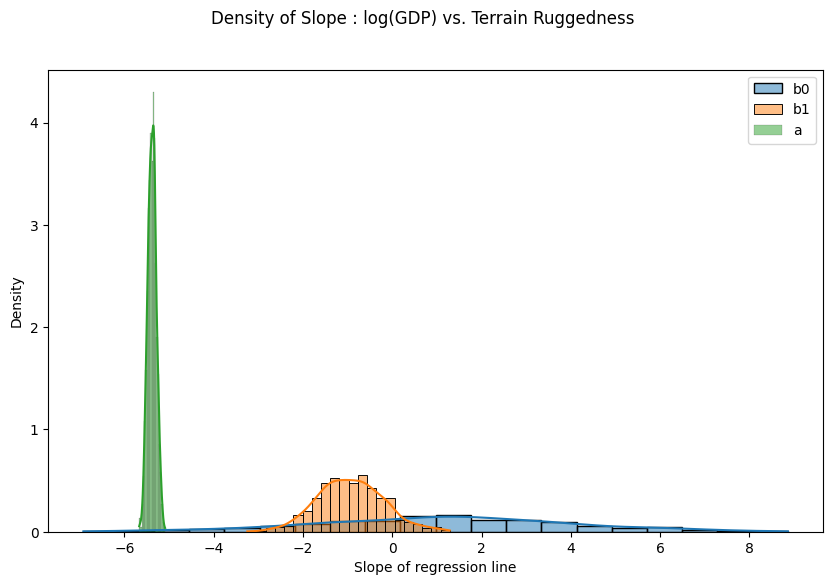

In [17]:
with pyro.plate("samples", 800, dim=-1):
    samples = guide(contributers, data)

sample_0 = samples["b_0"]
sample_1 = samples["b_1"]
sample_a = samples["a"]
#sample_s = samples["sigma"]

fig = plt.figure(figsize=(10, 6))
sns.histplot(sample_0.detach().cpu().numpy(), kde=True, stat="density", label="b0")
sns.histplot(sample_1.detach().cpu().numpy(), kde=True, stat="density", label="b1")
sns.histplot(sample_a.detach().cpu().numpy(), kde=True, stat="density", label="a")
#sns.histplot(sample_s.detach().cpu().numpy(), kde=True, stat="density", label="sigma")

fig.suptitle("Density of Slope : log(GDP) vs. Terrain Ruggedness")
plt.xlabel("Slope of regression line")
plt.legend()
plt.show()

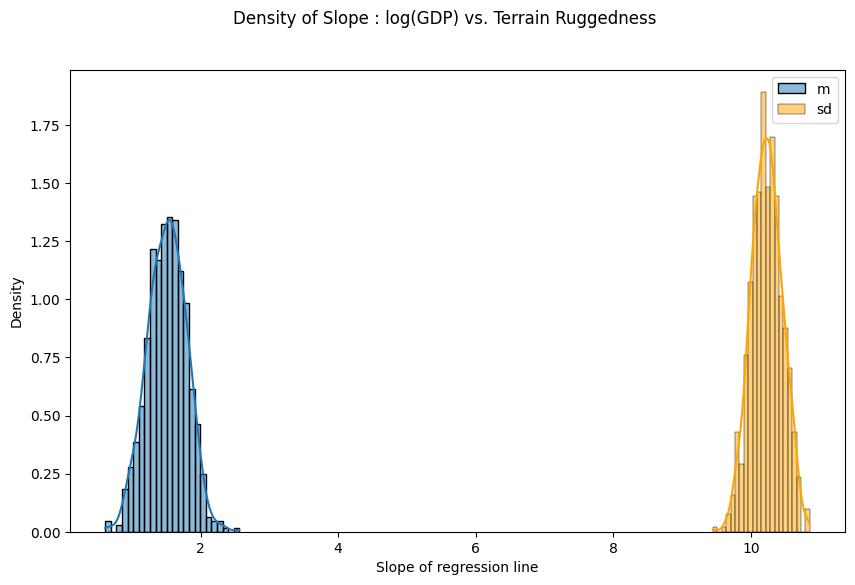

In [55]:
num_iters = 5000 if not smoke_test else 2
guide, svi = get_svi(model3)
# runs with models 3b and 3c

for i in range(num_iters):
    elbo = svi.step(c0.squeeze(-1), c1.squeeze(-1), data)
    if i % 500 == 0:
        print("Elbo loss: {}".format(elbo))

with pyro.plate("samples", 800, dim=-1):
    samples = guide(contributers, data)

sample_m = samples["m"]
sample_sd = samples["sd"]

fig = plt.figure(figsize=(10, 6))
sns.histplot(sample_m.detach().cpu().numpy(), kde=True, stat="density", label="m")
sns.histplot(sample_sd.detach().cpu().numpy(), kde=True, stat="density", label="sd", color="orange")
fig.suptitle("Density of Slope : log(GDP) vs. Terrain Ruggedness")
plt.xlabel("Slope of regression line")
plt.legend()
plt.show()

In [49]:
svi

In [35]:
(torch.tensor([1, 2, 3]) == 1) * torch.ones(3)

tensor([1., 0., 0.])

In [2]:
import pyro
import torch
import os
import matplotlib.pyplot as plt
import logging

%matplotlib inline
plt.style.use('default')

logging.basicConfig(format='%(message)s', level=logging.INFO)
smoke_test = ('CI' in os.environ)

def gen_data(gen_avg, gen_sig, n_samples, contributer_coefficients):
    """generate random data.
    
    Inputs:
    * gen_avg: mean for the baseline
    * gen_sig: sigma for the baseline
    * n_samples: number of samples
    * contributer_coefficients: dictionary with (mean,sig) per level per contributer
    
    Outputs:
    * data: array with the final number
    * contributers: matrix defining the contributers, first column is for the first level"""
    
    data = np.random.normal(gen_avg, gen_sig, n_samples)
    contributers = np.zeros((n_samples, len(contributer_coefficients)))
    for lvl, cdict in contributer_coefficients.items():
        print(f"creating level {lvl}")
        lvl_influencers = len(cdict) #number of influencers in this level
        lvldata = np.zeros((n_samples, lvl_influencers))

        for i, (mu,sig) in cdict.items():
            lvldata[:,i] = np.random.normal(mu, sig, n_samples)

        selection = np.random.randint(low=0,
                                    high=lvl_influencers,
                                    size=(n_samples))
        contributers[:, lvl] = selection
        
        data += np.array([lvldata[row, col] for row, col in enumerate(selection)])
    return torch.from_numpy(data), torch.from_numpy(contributers)

# parameters for the two contributors in level 0
cc_01 = {0: {    0: (1, 1),
                1: (2, 1)}}

# generate the data
data, contributers = gen_data(gen_avg=0,
                              gen_sig=10,
                              n_samples=1000,
                              contributer_coefficients=cc_01)

pyro.clear_param_store()
def model(contributers, data):
    
    a = pyro.sample("a", dist.Normal(0., 10.))
    b_0 = pyro.sample("b1", dist.Normal(0., 1.))
    b_1 = pyro.sample("b2", dist.Normal(0., 1.))

    sigma = pyro.sample("sigma", dist.Uniform(0., 10.))
    mean = (a + (contributers == 0) * b_0 + (contributers == 1) * b_1).to_event()
    
    with pyro.plate("data", len(data)):
        pyro.sample("obs", dist.Normal(mean, sigma), obs=data)


guide = AutoMultivariateNormal(model, init_loc_fn=init_to_mean)
svi = SVI(model,
          guide,
          optim.Adam({"lr": .01}),
          loss=Trace_ELBO())

num_iters = 100 if not smoke_test else 2

for i in range(num_iters):
    elbo = svi.step(contributers, data)
    if i % 500 == 0:
        print("Elbo loss: {}".format(elbo))

c:\Users\fuerf\AppData\Local\Programs\Python\Python312\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


creating level 0


AttributeError: 'Tensor' object has no attribute 'to_event'

# Statistics tests


In [39]:
a = np.random.normal(2, 4, 1000)
b = np.random.normal(1, 3, 1000)
c = np.random.normal(-1, 2, 1000)

In [40]:
np.var(a)

16.648026296727984

In [41]:
np.var(b)

9.277377858276934

In [42]:
np.var(c)

4.029863523398239

In [43]:
np.var(a+b)

25.60709834679312

In [44]:
np.var(a+c)

21.055894142584364

In [47]:
np.mean(a+c)

0.9292185655598205